# The Lightweight Data Stack 
## Redpanda + Bytewax + DuckDB

Back when I worked at GitHub, we pulled many of our metrics out of a data source we called requests. This was an accumulation of all (or nearly all) of the HTTP requests across the GitHub products. The data originated from logs generated from web servers or in some cases from a load balancer. This data allowed us to determine things like who is using which parts of the product and how they are using the product. It turns out this is a more common source of data than just GitHub. Companies often lack perfect telemetry for their products and in order to get information on what is happening, we can look to the server log data.

Most often, the raison d'etre of a data team is to facilitate answers to questions like we had at GitHub. Who is using the product and how are they using it. The root capability required to answer question like we at GitHub had, is the ability to count things reliably and at scale.

![quote: the ability to count things reliably and at scale](img/quote.png)

What I am going to show in this tutorial is how you can set up a relatively lightweight data stack that will serve in providing answers to who is using our product and how are they using it. The architecture and solution is a departure from the often talked about modern data stack, which often ends up being expensive, 100% hosted and possibly a lot more than you need. This Data Stack can run on any cloud, could scale with your business and provide all the capabilities you require, this ain't no toy data stack. But... it also might lack some of the frills of the often touted modern data stack.

This iteration of the lightweight data stack as is summarized in the diagram below uses [Redpanda](https://redpanda.com/), [Bytewax](https://www.bytewax.io/) and [DuckDB](https://duckdb.org/). Redpanda serves as the streaming platform, Bytewax as the processing substrate for EL and some T and then duckDB as a serverless query engine for exploration.

---------

For this tutorial we are using web server access logs sourced from Kaggle and we have sampled the first 1000. You can find the full log file [here](https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs?resource=download). To start, we are going to run a Redpanda cluster, create a topic and load it with the log data. Then, we will write a dataflow that will parse the logs and store them in s3 (we will actually mock this part with local storage instead). Then we will show you how you can use duckDB to query them.

## Redpanda

For your production use case, it is recommended that you run Redpanda directly on the machine/vm and not in docker, for this tutorial we are going to run our Redpanda cluster in a docker container for simplicity and easy setup/teardown. Refer to the [Redpanda Documentation](https://docs.redpanda.com/docs/home/) for more in-depth setup and configuration details.

```bash
docker run -d --pull=always --name=redpanda-1 --rm \
-p 8081:8081 \
-p 8082:8082 \
-p 9092:9092 \
-p 9644:9644 \
docker.redpanda.com/vectorized/redpanda:latest \
redpanda start \
--overprovisioned \
--smp 1  \
--memory 1G \
--reserve-memory 0M \
--node-id 0 \
--check=false
```

Now that we have our streaming platform set up, let's create a new topic and simulate logging some data for downstream consumption. If you've cloned this notebook locally, you can run the cell below directly from the notebook. Before doing so, you may need to install the correct requirements from `requirements.txt` with the command below.

```python
pip install -r requirements.txt
```

In [25]:
from kafka import KafkaProducer
from kafka.admin import KafkaAdminClient, NewTopic
from kafka.errors import KafkaError
from time import sleep

input_topic_name = "server_request_logs"
localhost_bootstrap_server = "localhost:9092"
producer = KafkaProducer(bootstrap_servers=[localhost_bootstrap_server])
admin = KafkaAdminClient(bootstrap_servers=[localhost_bootstrap_server])

# Create input topic
try:
    input_topic = NewTopic(input_topic_name, num_partitions=6, replication_factor=1)
    admin.create_topics([input_topic])
    print(f"input topic {input_topic_name} created successfully")
except:
    print(f"Topic {input_topic_name} already exists")

# Add data to input topic
try:
    for line in open("input_data/first1000.log"):
        producer.send(input_topic_name, value=line.encode())
        sleep(0.01)
    print(f"input topic {input_topic_name} populated successfully")
except KafkaError:
    print("An error occurred")

input topic server_request_logs created successfully
input topic server_request_logs populated successfully


Now that we have the logs loaded into a Redpanda topic, we are going to create an ingestion pipeline that uses Bytewax. The Bytewax dataflow python file is located in the repository and we will walk through it in this notebook. To run the dataflow before reading through the tutorial, simply run 

```bash
$ python dataflow.py
```

`dataflow.py` will take the raw logs as an input from Redpanda, enrich them, parse them, and then write them to a file store in a columnar format (parquet). We are doing some minor enrichment directly in the dataflow, this may be prohibitive depending on your scale and requirements.

_If you are doing ip <-> geolocation enrichment as we are in this tutorial, I would recommend using the python package geoip2 with a database to decrease the latency._

Let's walk through the dataflow.

## Dataflow

There are 3 parts to the dataflow.

- **Input**
- **Parsing & Enrichment**
- **Output.**

![diagram of 3 parts](img/dataflow_lds.png)

The code to describe the dataflow is the following:

```python
flow = Dataflow()
flow.map(modify_key)
flow.map(enrichment)
flow.reduce_epoch(accumulate_logs)
flow.map(parse_logs)
flow.capture()
```

and to call the data flow we will run

```python
if __name__ == "__main__":
    spawn_cluster(flow, input_config, output_builder, recovery_config=recovery_config, proc_count=2)
```


### Input - Ingesting and recovery from Kafka

Bytewax has a handy Kafka input mechanism called `KafkaInputConfig` that keeps the necessary kafka consumer code to a minimum. There is also a recovery mechanism called `KafkaRecoveryConfig` that will use kafa API compatible services like Redpanda as the recovery store.

```python
input_config = KafkaInputConfig(
        RP_BROKERS, RP_TOPIC_GROUP_ID, RP_TOPIC, messages_per_epoch=100
    )
    recovery_config = KafkaRecoveryConfig(
    RP_BROKERS,
    "requests",
    )
```

These configurations will be used in the command to build a cluster of Bytewax dataflow workers in the main function. So the whole code in main will look like:  

```python
if __name__ == "__main__":
    input_config = KafkaInputConfig(
        RP_BROKERS, RP_TOPIC_GROUP_ID, RP_TOPIC, messages_per_epoch=100
    )
    recovery_config = KafkaRecoveryConfig(
    RP_BROKERS,
    "requests",
    )
    cluster_main(flow, input_config, output_builder, [], 0)
```

In the case if our dataflow infra fails, our dataflow will recover its state from the recovery store we have configured. In this example, we are starting with only a single process and a single worker. If we had multiple partitions, we would modify these to increase the throughput. 

### Parsing & Enrichment - Turning Logs into Data

For the bulk of the dataflow we are going to:
1. `modify_key` - this will modify the initial payload for aggregation. Nothing much going on here for this example.
2. `enrichment`
  a. Reformat the log string to more easily parse the date string
  b. Get the IP address from the log string and make a request to ipapi for the geolocation
3. `accumulate_logs` - Accumulating a batch of logs
4. `parse_logs` - Parse the logs into a columnar table format for writing

Since we are using a single partition and we are not concerned with parallelization in this example, we will ignore the `modify_key` step. The explanation for this step is that when we accumulate data, we would do it on a key and this first step would be used to pull out the key and put it as the first item in a tuple format for the accumulate step. 

_Our logs are byte strings and we will keep them in that format until we parse them. This will allow us to leverage pyarrow's csv_reader which will limit the need for us to write any funky regex._

#### Part 1 - IP <-> Geolocation

We are using a free service called ipapi that will return a geolocation from an ip for free. This requires us to make a http request and I would not recommend this for your production service because of latency and an increased chance of errors, but rather it would be better to use a ip <-> geolocation database service like [max mind](https://github.com/maxmind/GeoIP2-python). 

In the code below, we are also doing a touch of formatting that will allow us to easily parse the date. 

```python
def enrichment(data):
    key, log = data
    log = log.decode().replace('[','"').replace(']','"') # to parse datetime
    ip_address = log.split()[0]
    response = requests.get(f'https://ipapi.co/{ip_address}/json/')
    response_json = response.json()
    if response_json.get('error'):
        city, region, country = "-", "-", "-"
    else:
        city, region, country = response_json.get("city"), response_json.get("region"), response_json.get("country_name")
    location_data = '"' + '" "'.join([city, region, country]) + '"'
    return (key, b" ".join([location_data.encode(), log.encode()]))
```

#### Part 2 - Accumulate Logs

This function will be called inside of a stateful operator that will accumulate the logs across the size of the batch specified in the `kafkaInputConfig`

```python
def accumulate_logs(logs, log):
    return logs + '\n'.encode() + log
```

#### Part 3 - Parse Logs

Here we use the pyarrow csv_reader to parse out the line separated, space delimited byte string file object into a pyarrow table with the columns listed below. The table object returned is what we will use to write the files into parquet files with the correct metadata and partitioning.

```python
def parse_logs(epoch__logs):
    epoch, logs = epoch__logs
    logs = BytesIO(logs)
    parse_options = csv.ParseOptions(delimiter=" ")
    read_options = csv.ReadOptions(
        column_names=["city", "region", "country", "ip", "1-", "2-", "event_time", "request_url",
        "status_code", "3-", "request_referrer", "user_agent", "4-"])
    table = csv.read_csv(logs, parse_options=parse_options, read_options=read_options)
    event_time = table["event_time"].to_pylist()
    table = table.append_column("year", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').year for x in event_time]])
    table = table.append_column("month", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').month for x in event_time]])
    table = table.append_column("day", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').day for x in event_time]])
    table = table.append_column("hr", [[datetime.datetime.strptime(x, '%d/%b/%Y:%H:%M:%S %z').hour for x in event_time]])
    return table
```

Now that we have returned the output table we can capture the data to a sink. 

### Output - Capturing the Data

In the final step, capturing the output in a sink, we are using pyarrow once more. In this example, we are using a filestore, but you could easily modify this to use the other available storage options from pyarrow (S3 and Azure Blob at this time).

```python
def write_to_fs(epoch__table):
    epoch, table = epoch__table
    local = fs.LocalFileSystem()
    ds.write_dataset(
        table,
        format='parquet',
        base_dir=ROOT_FOLDER,
        partitioning=["year", "month", "day", "hr"],
        filesystem=local,
        existing_data_behavior='overwrite_or_ignore',
        basename_template = "part-{i}-" + uuid.uuid4().hex + ".parquet"
    )
```

## Analysis and Insights

Assuming you have already run the dataflow, you should have some data stored in the `data` directory on your machine. 

Now let's get some insights!

We are going to use duckdb, a newer, open source query engine that can quickly query across columnar formats like parquet from our local laptop with very little configuration and no additional infra. 

In [37]:
import duckdb
import pandas as pd

As an example, we could try and determine the most common locations that our users use our products from.

<AxesSubplot:xlabel='country'>

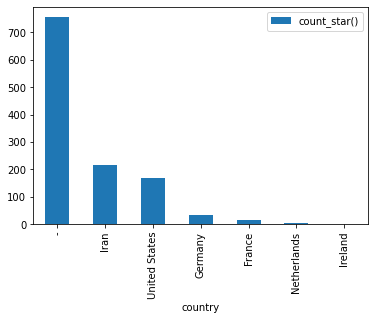

In [38]:
location_data = duckdb.query('''SELECT 
country, 
count(*) 
FROM 'data/2019/1/22/*/*.parquet' 
GROUP BY country
ORDER BY 2 desc''').df()
location_data.set_index('country', inplace=True)
location_data.plot.bar()

Or we could look at the status codes we've received across our data range.

<AxesSubplot:xlabel='status_code'>

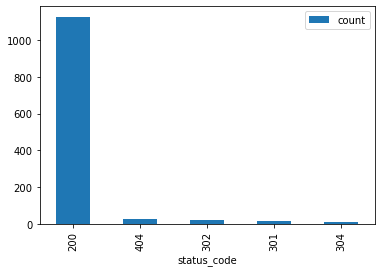

In [44]:
status_codes = duckdb.query('''SELECT 
status_code,
count(*) as count
FROM 'data/2019/1/22/*/*.parquet'
GROUP BY status_code
ORDER BY count desc
''').df()
status_codes.set_index('status_code', inplace=True)
status_codes.plot.bar()

And then isolate the ip address for each of the status codes that was not a 200 request to see if there are an common offenders.

In [40]:
non_200 = duckdb.query('''SELECT 
status_code,
ip,
count(*) as count
FROM 'data/2019/1/22/*/*.parquet'
WHERE status_code != 200
GROUP BY status_code, ip
ORDER BY count desc
''').df()
non_200

,status_code,ip,count
0,404,66.249.66.194,13
1,302,66.249.66.194,11
2,404,5.211.97.39,11
3,301,5.160.157.20,7
4,304,5.209.127.187,7
5,302,17.58.102.43,3
6,301,17.58.102.43,2
7,301,66.249.66.195,1
8,302,54.36.148.161,1
9,302,54.36.149.11,1


In [41]:
non_200_raw = duckdb.query('''SELECT 
*
FROM 'data/2019/1/22/*/*.parquet'
WHERE status_code != 200
''').df()
non_200_raw

,city,region,country,ip,1-,2-,event_time,request_url,status_code,3-,request_referrer,user_agent,4-
0,-,-,-,17.58.102.43,-,-,22/Jan/2019:03:58:06 +0330,GET /filter/b571%2Cb288%2Cb514%2Cb19%2Cb519%2C...,301,178,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1...,-
1,Ashburn,Virginia,United States,66.249.66.194,-,-,22/Jan/2019:03:58:09 +0330,GET /m/product/7524?model=9206 HTTP/1.1,302,0,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,-
2,Tehran,Tehran,Iran,5.211.97.39,-,-,22/Jan/2019:03:58:19 +0330,HEAD /amp_preconnect_polyfill_404_or_other_err...,404,0,https://www.zanbil.ir/m/browse/meat-grinder/%D...,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like...,-
3,-,-,-,54.36.149.11,-,-,22/Jan/2019:03:58:40 +0330,GET /filter/588%7C3%20%D9%84%DB%8C%D8%AA%D8%B1...,302,0,-,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,-
4,-,-,-,5.160.157.20,-,-,22/Jan/2019:03:58:50 +0330,GET /filter?f=p12129&page=19 HTTP/1.1,301,178,-,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-,-,-,207.46.13.104,-,-,22/Jan/2019:03:56:46 +0330,GET /browse/flute-keys/www.zanbil.ir HTTP/1.1,404,33605,-,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,-
66,Karaj,Alborz Province,Iran,5.160.157.20,-,-,22/Jan/2019:03:56:49 +0330,GET /filter?f=p12129&page=21 HTTP/1.1,301,178,-,Mozilla/5.0 (Windows NT 5.1; rv:8.0) Gecko/201...,-
67,Tehran,Tehran,Iran,5.211.97.39,-,-,22/Jan/2019:03:57:16 +0330,HEAD /amp_preconnect_polyfill_404_or_other_err...,404,0,https://www.zanbil.ir/m/filter/p25%2Cb103%2Cb50,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_2 like...,-
68,-,-,-,66.249.66.194,-,-,22/Jan/2019:03:57:44 +0330,GET /m/product/25816/53071/%D8%B3%D8%A7%DA%A9%...,302,0,-,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,-


That is interesting. Let's look at who those might be?

In [42]:
from ipwhois import IPWhois
from pprint import pprint

for ip in non_200['ip'].to_list():
    obj = IPWhois(ip)
    results = obj.lookup_rdap(depth=1)
    print(results['asn_description'])
    

GOOGLE, US
GOOGLE, US
MCCI-AS, IR
AZMA-AS, IR
MCCI-AS, IR
APPLE-ENGINEERING, US
APPLE-ENGINEERING, US
GOOGLE, US
OVH, FR
OVH, FR
MICROSOFT-CORP-MSN-AS-BLOCK, US
OVH, FR
MICROSOFT-CORP-MSN-AS-BLOCK, US
MICROSOFT-CORP-MSN-AS-BLOCK, US
AMAZON-AES, US
OVH, FR
GOOGLE, US
OVH, FR
WOW, US
GOOGLE, US
OVH, FR
OVH, FR
MCCI-AS, IR


We won't dive any deeper than this at the moment as I think this demonstrates what you need to get started answering your relevant business questions with the Lightweight Data Stack.